### Deeptanshu Kumar
#### [Hugging Face](https://huggingface.co/Deeptanshu13)
#### [Github](https://github.com/deeptanshukumar/)

## Synthetic Data Generation and LLM Fine-tuning

### Overview
1. Create a synthetic dataset for a use case of your choice
2. Fine-tune a small LLM using this dataset
3. Evaluate the model performance before and after fine-tuning
4. Use small language models (eg Llama 3.2 1B and Qwen 3 0.6B / 1.7B) that can run on T4 GPUs


# Problem Statement
**An AI-powered Healthcare Reasoning/Consultation Assistant for India. This addresses the critical need to counter Western data bias in health models by grounding its responses with generated Indian context notes.**

The model functions as a doctor, taking a natural language symptom query and providing a likely disease, precautions, a rationale, and advice on seeking professional help.

**The reason for countering data bias is because most of these models are trained on western data and in those countries people encounter different diseases and have different symptoms whereas as compared to Africa or India (where data is scarce)**


## 2. Environment Setup
- Data processing and manipulation
- LLM access and fine-tuning
- Evaluation metrics
- Hugging Face integration for dataset upload and model download


In [ ]:
# Install necessary dependencies
!pip install -q transformers datasets evaluate peft bitsandbytes accelerate
!pip install -q huggingface_hub
!pip install -q trl # trl is used for fine tuning and allows to import sfttrainer for fine tuning
!pip install -q nltk rouge-score sacrebleu

# Optional: For specific use cases
# !pip install -q sentencepiece tokenizers
# !pip install -q gradio # For demo creation

# Login to Hugging Face (you'll need a token)
from huggingface_hub import login
# Uncomment the line below and add your token when ready to upload datasets
login()
# USE THE TOKEN TO ACCESS THE MODELS, ONLY THEN THE NB WILL WORK!

# Verify installations
import transformers
import datasets
import peft

print(f"Transformers version: {transformers.__version__}")
print(f"Datasets version: {datasets.__version__}")
print(f"PEFT version: {peft.__version__}")

# Check available GPU
!nvidia-smi
# ideally a T4 or A100 GPU

Transformers version: 4.56.1
Datasets version: 4.0.0
PEFT version: 0.17.1
Fri Oct  3 15:57:08 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   43C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                       

# Synthetic Data Generation
1. Defining the data structure and schema
2. Setting up data generation techniques (LLM prompting, rules-based generation, etc.)
3. Creating the dataset
4. Validating data quality
5. Uploading to Hugging Face Datasets

In [ ]:
import pandas as pd
from datasets import Dataset
from tqdm.auto import tqdm


### Loading our dataset from kaggle (4 CSV files)

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("itachi9604/disease-symptom-description-dataset")

print("Path to dataset files:", path)


df_symptoms = pd.read_csv(f"{path}/dataset.csv")
df_desc = pd.read_csv(f"{path}/symptom_Description.csv")
df_precautions = pd.read_csv(f"{path}/symptom_precaution.csv")
df_severity = pd.read_csv(f"{path}/Symptom-severity.csv")

print("dataset.csv:", df_symptoms.shape)
print("symptom_Description.csv:", df_desc.shape)
print("symptom_precaution.csv:", df_precautions.shape)
print("Symptom-severity.csv:", df_severity.shape)

df_symptoms.head()


# the kaggle dataset has been loaded and store in the path: /kaggle/input/disease-symptom-description-dataset


100%|██████████| 30.1k/30.1k [00:00<00:00, 35.6MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/itachi9604/disease-symptom-description-dataset/versions/2
dataset.csv: (4920, 18)
symptom_Description.csv: (41, 2)
symptom_precaution.csv: (41, 5)
Symptom-severity.csv: (133, 2)


,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17
0,Fungal infection,itching,skin_rash,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Fungal infection,skin_rash,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Fungal infection,itching,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Fungal infection,itching,skin_rash,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Fungal infection,itching,skin_rash,nodal_skin_eruptions,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
def get_symptom_list(row):
    values = row[1:].values #getting all precaution values
    symptom_list = []
    for s in values:
        if pd.notna(s):
            symptom_list.append(s)
    return symptom_list # list containing all symptom values for a disease (not NULL)


df_symptoms["symptoms_list"] = df_symptoms.apply(get_symptom_list, axis=1) #adding the symptoms list as a column for all rows
df_symptoms = df_symptoms[["Disease", "symptoms_list"]]
df_symptoms.rename(columns={"Disease": "suspected_disease"}, inplace=True) #renaming it to suspected disease since its apt

df_merged = df_symptoms.merge(df_desc, left_on="suspected_disease", right_on="Disease", how="left")
df_merged = df_merged.merge(df_precautions, left_on="suspected_disease", right_on="Disease", how="left")
df_merged.drop(columns=["Disease_x", "Disease_y"], inplace=True, errors="ignore") #removing rhe redundant disease columns we got
# from the df_desc and df_precautions

df_merged.head(3)


,suspected_disease,symptoms_list,Description,Precaution_1,Precaution_2,Precaution_3,Precaution_4
0,Fungal infection,"[itching, skin_rash, nodal_skin_eruptions, ...","In humans, fungal infections occur when an inv...",bath twice,use detol or neem in bathing water,keep infected area dry,use clean cloths
1,Fungal infection,"[ skin_rash, nodal_skin_eruptions, dischromi...","In humans, fungal infections occur when an inv...",bath twice,use detol or neem in bathing water,keep infected area dry,use clean cloths
2,Fungal infection,"[itching, nodal_skin_eruptions, dischromic _...","In humans, fungal infections occur when an inv...",bath twice,use detol or neem in bathing water,keep infected area dry,use clean cloths


In [ ]:
#Generating the symptoms scores (sum of symptoms severities for a disease row)
symptoms = df_severity["Symptom"]
weights = df_severity["weight"]
severity_map = dict(zip(symptoms, weights))

def calc_severity(symptoms_list):
    total_severity = 0
    for symptom in symptoms_list:
        clean_symptom = symptom.strip()
        weight = severity_map.get(clean_symptom, 0)
        total_severity += weight

    return total_severity

#applying the function to the DataFrame
df_merged["severity_score"] = df_merged["symptoms_list"].apply(calc_severity)

display(df_merged.head())


,suspected_disease,symptoms_list,Description,Precaution_1,Precaution_2,Precaution_3,Precaution_4,severity_score
0,Fungal infection,"[itching, skin_rash, nodal_skin_eruptions, ...","In humans, fungal infections occur when an inv...",bath twice,use detol or neem in bathing water,keep infected area dry,use clean cloths,8
1,Fungal infection,"[ skin_rash, nodal_skin_eruptions, dischromi...","In humans, fungal infections occur when an inv...",bath twice,use detol or neem in bathing water,keep infected area dry,use clean cloths,7
2,Fungal infection,"[itching, nodal_skin_eruptions, dischromic _...","In humans, fungal infections occur when an inv...",bath twice,use detol or neem in bathing water,keep infected area dry,use clean cloths,5
3,Fungal infection,"[itching, skin_rash, dischromic _patches]","In humans, fungal infections occur when an inv...",bath twice,use detol or neem in bathing water,keep infected area dry,use clean cloths,4
4,Fungal infection,"[itching, skin_rash, nodal_skin_eruptions]","In humans, fungal infections occur when an inv...",bath twice,use detol or neem in bathing water,keep infected area dry,use clean cloths,8


In [ ]:
df_merged.describe()

,severity_score
count,4920.000000
mean,30.731707
std,16.543682
min,4.000000
25%,18.000000
50%,27.000000
75%,42.250000
max,77.000000


The df_merged is now our main dataset which we will be working on, this contains the columns
**suspected_disease, symptoms_list, 	Description, 	Precaution_1, 	Precaution_2, 	Precaution_3, 	Precaution_4, 	severity_score**

In [ ]:
#Counting how many times each disease appears in the dataset
disease_counts = df_merged['suspected_disease'].value_counts()

# Show the count of each unique disease
print("Count of each unique disease in the dataset:")
print(disease_counts)

unique_diseases = df_merged['suspected_disease'].unique()
print(f"\nNumber of unique diseases in the dataset: {len(unique_diseases)}")

Count of each unique disease in the dataset:
suspected_disease
Fungal infection                           120
Allergy                                    120
GERD                                       120
Chronic cholestasis                        120
Drug Reaction                              120
Peptic ulcer diseae                        120
AIDS                                       120
Diabetes                                   120
Gastroenteritis                            120
Bronchial Asthma                           120
Hypertension                               120
Migraine                                   120
Cervical spondylosis                       120
Paralysis (brain hemorrhage)               120
Jaundice                                   120
Malaria                                    120
Chicken pox                                120
Dengue                                     120
Typhoid                                    120
hepatitis A                                1

We can see that out dataset has 41 unique diseases with 120 entries for each.
This means out dataset is equally distributed and no bias is shown.

Now we will take 15 rows per disease, random sample it, then we will augument 615 more to later have a total of 1200 data points for fine tuning.

In [ ]:
#sampling 15 rows per disease randomly though
sampled_list = []
rows_per_disease = 15

for disease in df_merged['suspected_disease'].unique():
    df_disease = df_merged[df_merged['suspected_disease'] == disease]
    df_sampled = df_disease.sample(n=rows_per_disease, random_state=42)
    sampled_list.append(df_sampled)

#combine all sampled rows into a single dataframe
df_subset = pd.concat(sampled_list).reset_index(drop=True)
print("Number of rows in the subset:", df_subset.shape[0])

df_subset.head()


Number of rows in the subset: 615


,suspected_disease,symptoms_list,Description,Precaution_1,Precaution_2,Precaution_3,Precaution_4,severity_score
0,Fungal infection,"[itching, skin_rash, nodal_skin_eruptions]","In humans, fungal infections occur when an inv...",bath twice,use detol or neem in bathing water,keep infected area dry,use clean cloths,8
1,Fungal infection,"[itching, skin_rash, dischromic _patches]","In humans, fungal infections occur when an inv...",bath twice,use detol or neem in bathing water,keep infected area dry,use clean cloths,4
2,Fungal infection,"[itching, skin_rash, nodal_skin_eruptions]","In humans, fungal infections occur when an inv...",bath twice,use detol or neem in bathing water,keep infected area dry,use clean cloths,8
3,Fungal infection,"[ skin_rash, nodal_skin_eruptions, dischromi...","In humans, fungal infections occur when an inv...",bath twice,use detol or neem in bathing water,keep infected area dry,use clean cloths,7
4,Fungal infection,"[itching, nodal_skin_eruptions, dischromic _...","In humans, fungal infections occur when an inv...",bath twice,use detol or neem in bathing water,keep infected area dry,use clean cloths,5


## Now the 615 rows dataset (which is a subset of our main dataset) is where we start working on Synthetic data generation and augumentation


#Synthetic data generation process

In [ ]:
!pip install -q transformers accelerate pandas tqdm
import pandas as pd
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from tqdm import tqdm

# df_subset already contains 15 rows per disease
print("Number of rows in df_subset:", df_subset.shape[0])

Number of rows in df_subset: 615


In [ ]:
model_name = "google/gemma-3-1b-it"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto")
batchsize = 16

text_gen = pipeline(
    task="text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=84,
    do_sample=True,
    temperature=0.3
) #loading and setting up model

#why i chose a larger model? to develop quality answers
#will be choosing a smaller model later for purpose of paraphrasing (to increase speed)

tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/899 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.00G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
# Creating prompts
def create_rationale_prompt(row):
    return f"""Symptoms: {', '.join(row['symptoms_list'])}
Disease: {row['suspected_disease']}
Severity: {row['severity_score']}
Explain briefly in one sentence why the recommendation was made.
Do not include the prompt text."""


def create_indian_prompt(row):
    return f"""Provide Indian healthcare context for the following case:
Symptoms: {', '.join(row['symptoms_list'])}
Disease: {row['suspected_disease']}
Include local conditions, Hindi term, rural/urban factor. Only provide the explanation."""


rationale_prompts = df_subset.apply(create_rationale_prompt, axis=1).tolist()
indian_prompts = df_subset.apply(create_indian_prompt, axis=1).tolist()

In [ ]:
# rule based :  if the disease is a part of the critical disease list, the ai will by default advice the patient to go to the doctor apart
critical_diseases = [
    "AIDS", "Diabetes ", "Hypertension ", "Heart attack",
    "Paralysis (brain hemorrhage)", "Malaria", "Typhoid",
    "hepatitis A", "Hepatitis B", "Hepatitis C", "Hepatitis D",
    "Hepatitis E", "Alcoholic hepatitis", "Tuberculosis",
    "Pneumonia", "Dimorphic hemmorhoids(piles)", "Heart attack",
    "Varicose veins", "Hypothyroidism", "Hyperthyroidism",
    "Hypoglycemia", "Osteoarthristis", "Arthritis",
    "(vertigo) Paroymsal Positional Vertigo", "Acne",
    "Urinary tract infection", "Psoriasis", "Impetigo", "Jaundice"
]

def doctor_visit_recommendation(severity, disease):
    """Simplified for severity 0-1 and critical disease override."""
    if disease in critical_diseases:
        return "Consult doctor immediately"
    if severity <20:
        return "No need to consult a doctor; monitor at home."
    elif severity >=20:
        return "Consult a doctor if symptoms worsen or persist."
    else:
        return "Seek medical advice if unsure."


doctor_visit_outputs = [doctor_visit_recommendation(sev, dis) for sev, dis in zip(df_subset["severity_score"], df_subset["suspected_disease"])]
#generating a list of doctor_visit_recommendation outputs

#batch wise processing
def generate_batch(prompts, batch_size=batchsize):
    all_outputs = []
    for i in tqdm(range(0, len(prompts), batch_size)): #tqdm is just a progress bar, batch size is selcted as 16, so 16 prompts get inputted to the llm for generation, also the skip here is the batch size number
        batch = prompts[i:i+batch_size]
        outputs = text_gen(batch, batch_size=batch_size) #16 prompt outputs are returned
        for item in outputs:
            text = item[0]["generated_text"].strip()
            all_outputs.append(text)   #every prompt is then cleaned and extracted and appended to the all_outputs list
    return all_outputs

print("Generating rationales...")
rationale_outputs = generate_batch(rationale_prompts, batch_size=batchsize) #sends in the prompt and the batch size and every "batch_size" number of prompts will go in and get
#generated, the outputs are returned as a list

print("Generating Indian context notes...")
indian_outputs = generate_batch(indian_prompts, batch_size=batchsize)


def clean_output(output, prompt):
    return output.replace(prompt, "").strip()  #remove any included prompts and remove any trailing whitespaces

rationale_cleaned = [clean_output(out, prmpt) for out, prmpt in zip(rationale_outputs, rationale_prompts)]
indian_cleaned = [clean_output(out, prmpt) for out, prmpt in zip(indian_outputs, indian_prompts)]




#merge into the final dataset and this our synthetic dataset
synthetic_df = df_subset.copy()
synthetic_df["when_to_consult_doctor"] = doctor_visit_outputs
synthetic_df["rationale"] = rationale_cleaned
synthetic_df["indian_context_notes"] = indian_cleaned

#saving this to a csv file
synthetic_df.to_csv("synthetic_healthcare_data.csv", index=False)
print("Saved as 'synthetic_healthcare_data.csv'")

Generating rationales...


100%|██████████| 39/39 [03:48<00:00,  5.85s/it]


Generating Indian context notes...


100%|██████████| 39/39 [03:47<00:00,  5.82s/it]

Saved as 'synthetic_healthcare_data.csv'


## Generating Input and Output Pairs (Q&A pairs)
we will generate the `input_text` and `output_text` columns for the synthetic dataset using. the input and output text need the context of the previous columns thats why they are generated now.

In [ ]:
!pip install -q transformers accelerate pandas tqdm

import pandas as pd
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from tqdm import tqdm

synthetic_df = pd.read_csv("synthetic_healthcare_data.csv")

# using a small model since it is fast and also we dont require any specific knowledge to do this, the model just takes the context and frames it in natural language
model_name = "Qwen/Qwen1.5-0.5B-Chat" #qwen is a very very fast model but the only slight trouble with this is that it might insert (rarely) some chinese symbols in between, but i couldnt find a faster model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

text_gen = pipeline(
    task="text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=128,
    do_sample=True,
    temperature=0.7,
    pad_token_id=tokenizer.eos_token_id
)

input_texts = []
output_texts = []

print(f"Generating input and output texts using {model_name}...")

for index, row in tqdm(synthetic_df.iterrows(), total=len(synthetic_df), desc="Generating rows"):
    symptoms = eval(row["symptoms_list"]) if isinstance(row["symptoms_list"], str) else row["symptoms_list"] #just checking if symptoms_list is parsed correctly or not since this part had an issue
    disease = row["suspected_disease"]
    rationale = row["rationale"]
    consult = row["when_to_consult_doctor"]
    indian = row["indian_context_notes"]
    precautions = [row[f"Precaution_{i}"] for i in range(1, 5) if pd.notna(row[f"Precaution_{i}"])]

    #code for input_text--------
    input_prompt = f"Write a short patient-style message to a doctor, describing these symptoms casually: {', '.join(symptoms)}."
    try:
        resp = text_gen(input_prompt, num_return_sequences=1)
        generated_text = resp[0]["generated_text"].strip()
        if generated_text.startswith(input_prompt):
            cleaned = generated_text[len(input_prompt):].strip()
            input_text = cleaned if cleaned else f"I’ve been having {', '.join(symptoms)} and I’m worried. What should I do?"
        else:
            input_text = generated_text

    except Exception as e:
        print(f"Error generating input text for row {index}: {e}")
        input_text = f"I’ve been having {', '.join(symptoms)} and I’m worried. What should I do?"

    #code for output_text--------
    output_text = (
        f"Based on your symptoms ({', '.join(symptoms)}), it looks like you may have {disease}. "
        f"{rationale} {consult}. "
        f"Here are some precautions you can take: {', '.join(precautions)}. "
        f"Additional context: {indian}"
    )

    input_texts.append(input_text)
    output_texts.append(output_text)

#save to dataframe
synthetic_df["input_text"] = input_texts
synthetic_df["output_text"] = output_texts

print("Added input_text and output_text to all rows.")
display(synthetic_df[["symptoms_list", "input_text", "output_text"]].head(10))

#save to CSV
synthetic_df.to_csv("synthetic_healthcare_data_augmented.csv", index=False)
print("Saved as 'synthetic_healthcare_data_augmented.csv'!")


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/661 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.24G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/206 [00:00<?, ?B/s]

Device set to use cuda:0


Generating input and output texts using Qwen/Qwen1.5-0.5B-Chat...


Generating rows: 100%|██████████| 615/615 [00:25<00:00, 24.10it/s]

Added input_text and output_text to all rows.


,symptoms_list,input_text,output_text
0,"['itching', ' skin_rash', ' nodal_skin_eruptio...","I’ve been having itching, skin_rash, nodal_s...","Based on your symptoms (itching, skin_rash, ..."
1,"['itching', ' skin_rash', ' dischromic _patches']","I’ve been having itching, skin_rash, dischro...","Based on your symptoms (itching, skin_rash, ..."
2,"['itching', ' skin_rash', ' nodal_skin_eruptio...","I’ve been having itching, skin_rash, nodal_s...","Based on your symptoms (itching, skin_rash, ..."
3,"[' skin_rash', ' nodal_skin_eruptions', ' disc...","I’ve been having skin_rash, nodal_skin_erupt...","Based on your symptoms ( skin_rash, nodal_ski..."
4,"['itching', ' nodal_skin_eruptions', ' dischro...","I’ve been having itching, nodal_skin_eruption...","Based on your symptoms (itching, nodal_skin_e..."
5,"['itching', ' skin_rash', ' nodal_skin_eruptio...","I’ve been having itching, skin_rash, nodal_s...","Based on your symptoms (itching, skin_rash, ..."
6,"['itching', ' skin_rash', ' nodal_skin_eruptio...","I’ve been having itching, skin_rash, nodal_s...","Based on your symptoms (itching, skin_rash, ..."
7,"['itching', ' skin_rash', ' nodal_skin_eruptio...","I’ve been having itching, skin_rash, nodal_s...","Based on your symptoms (itching, skin_rash, ..."
8,"['itching', ' skin_rash', ' nodal_skin_eruptio...","I’ve been having itching, skin_rash, nodal_s...","Based on your symptoms (itching, skin_rash, ..."
9,"['itching', ' skin_rash', ' nodal_skin_eruptio...","I’ve been having itching, skin_rash, nodal_s...","Based on your symptoms (itching, skin_rash, ..."


Saved as 'synthetic_healthcare_data_augmented.csv'!


### Now that the i/o pairs have been generated, we will no paraphrase the i/o pairs for every row, this means every row will produce another row thus totalling 1230 data points

In [ ]:
from tqdm import tqdm
import pandas as pd
import numpy as np # Import numpy for isnan checks

#Loading synthetic_healthcare_data_augmented.csv (should not have nulls here)
synthetic_df = pd.read_csv("synthetic_healthcare_data_augmented.csv")

aug_input_texts = []
aug_output_texts = []

print("Generating augmented/paraphrased rows...")

#We have defined the model before


for index, row in tqdm(synthetic_df.iterrows(), total=len(synthetic_df), desc="Augmenting data"):
    input_text = row["input_text"]
    output_text = row["output_text"]

    # Paraphrase input_text
    new_input_text = input_text #original will be kept as a fallback
    if pd.notna(input_text) and str(input_text).strip() != "": #only paraphrasing if original is not null/empty
        input_prompt = f"Paraphrase this patient-style message naturally: {input_text}"
        try:
            input_resp = text_gen(input_prompt, max_new_tokens=100, do_sample=True, temperature=0.8, num_return_sequences=1)
            generated_text = input_resp[0]["generated_text"]
            #only extracting the generated text
            if input_prompt in generated_text:
                start_index = generated_text.find(input_prompt) + len(input_prompt)
                temp_new_input_text = generated_text[start_index:].strip()
            else:
                temp_new_input_text = generated_text.strip()

            # Use the generated text only if it's not empty, otherwise keep the original
            if temp_new_input_text != "":
                new_input_text = temp_new_input_text

        except Exception as e:
            print(f"Error paraphrasing input_text at row {index}: {e}")
            pass #keep the original input_text

    # Paraphrase output_text
    new_output_text = output_text
    if pd.notna(output_text) and str(output_text).strip() != "":
        output_prompt = f"Paraphrase this doctor-style response naturally: {output_text}"
        try:
            output_resp = text_gen(output_prompt, max_new_tokens=150, do_sample=True, temperature=0.8, num_return_sequences=1)
            generated_text = output_resp[0]["generated_text"]
            if output_prompt in generated_text:
                 start_index = generated_text.find(output_prompt) + len(output_prompt)
                 temp_new_output_text = generated_text[start_index:].strip()
            else:
                 temp_new_output_text = generated_text.strip()

            if temp_new_output_text != "":
                new_output_text = temp_new_output_text

        except Exception as e:
            print(f"Error paraphrasing output_text at row {index}: {e}")
            pass


    # Append something even if paraphrasing fails or is empty, use placeholder/original if still null
    if pd.isna(new_input_text) or str(new_input_text).strip() == "":
         new_input_text = input_text if pd.notna(input_text) and str(input_text).strip() != "" else "Placeholder input."

    if pd.isna(new_output_text) or str(new_output_text).strip() == "":
         new_output_text = output_text if pd.notna(output_text) and str(output_text).strip() != "" else "Placeholder output."

    aug_input_texts.append(new_input_text)
    aug_output_texts.append(new_output_text)

#create the augmented df
augmented_df = pd.DataFrame({
    "input_text": aug_input_texts,
    "output_text": aug_output_texts
})

# Combine original + augmented → 1230 rows
final_df = pd.concat([synthetic_df, augmented_df], ignore_index=True)


final_df.to_csv("synthetic_healthcare_data_1230.csv", index=False)
print("Saved the augmented dataset as 'synthetic_healthcare_data_1230.csv'")

Generating augmented/paraphrased rows...


Augmenting data: 100%|██████████| 615/615 [12:48<00:00,  1.25s/it]

Saved the augmented dataset as 'synthetic_healthcare_data_1230.csv'


###IMPORTANT: my final dataset has 1230 rows in which the columns
**[input_text, output_text]** are 1230 in number and none are null

**[suspected_disease, 	symptoms_list, 	Description, 	Precaution_1,
Precaution_2, 	Precaution_3, 	Precaution_4, 	severity_score,
when_to_consult_doctor, rationale, indian_context_notes]** are 1230 in size but 615 of them are NULL since we needed to praphrase only the last 2 columns

so the uploaded dataset actually has the **last 2 columns useful for the FINE TUNING,** rest is just if anyone wants to use it


**Consider only the last 2 columns from the who dataset (which is uploaded on hugging face) to be useful**

# Uploading the dataset to Hugging Face

In [ ]:
from datasets import Dataset, DatasetDict
import pandas as pd
from tqdm.auto import tqdm


df = pd.read_csv("synthetic_healthcare_data_1230.csv")

dataset = Dataset.from_pandas(df)

train_test = dataset.train_test_split(test_size=0.2)

 # Upload to Hugging Face
dataset_dict = DatasetDict({
     "train": train_test["train"],
     "test": train_test["test"]
 })

dataset_dict.push_to_hub(
    "Deeptanshu13/synthetic_healthcare_data_qa_pairs",
    private=False
)

print("✅ Dataset uploaded to Hugging Face")


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

                              : 100%|##########|  389kB /  389kB            

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

                              : 100%|##########|  121kB /  121kB            

README.md:   0%|          | 0.00/895 [00:00<?, ?B/s]

✅ Dataset uploaded to Hugging Face


##Model Fine-tuning

Now that we have our synthetic dataset, let's fine-tune a small LLM using PEFT/LoRA techniques. This approach allows us to efficiently adapt the pre-trained model to our specific task without excessive computational requirements.

We'll:
1. Load the pre-trained model
2. Prepare the dataset in the correct format
3. Configure LoRA adapters
4. Fine-tune the model
5. Save the fine-tuned model

This section uses Parameter-Efficient Fine-Tuning (PEFT) with Low-Rank Adaptation (LoRA) to update only a small number of parameters, making it suitable for running on Colab's T4 GPU.

In [ ]:
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments
from trl import SFTTrainer
from peft import LoraConfig, get_peft_model
import pandas as pd
import torch
from tqdm.auto import tqdm

# Schema Used:
{ Input : {input_text} ,
Output: {output_text}
}


In [ ]:
try: #loading the dataset
    df = pd.read_csv("synthetic_healthcare_data_1230.csv")

    # Create 'text' column for training directly in pandas
    # Ensure handling of potential NaN values in input/output text
    df['text'] = df.apply(
        lambda row: f"### Input:\n{row['input_text']}\n\n### Output:\n{row['output_text']}"
        if pd.notna(row['input_text']) and pd.notna(row['output_text']) and row['input_text'] != '' and row['output_text'] != ''
        else '', axis=1
    )

    #Filtering out rows where text is empty
    df = df[df['text'] != ''].reset_index(drop=True)

    # Split dataframe into training and evaluation sets
    train_df = df.sample(frac=0.9, random_state=42) # 90% train
    eval_df = df.drop(train_df.index).reset_index(drop=True) # 10% eval
    train_df = train_df.reset_index(drop=True)


    # Convert back to Dataset objects
    train_data = Dataset.from_pandas(train_df)
    eval_data = Dataset.from_pandas(eval_df)

    print(f"Successfully loaded and split dataset. Training samples: {len(train_data)}, Evaluation samples: {len(eval_data)}")

except Exception as e:
    print(f"Error loading or splitting dataset: {e}")
    print("Please ensure 'synthetic_healthcare_data_1230.csv' is in the /content/ directory and has 'input_text' and 'output_text' columns.")
    raise e


Successfully loaded and split dataset. Training samples: 1107, Evaluation samples: 123


In [ ]:
model_id = "meta-llama/Llama-3.2-1B"
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token


# Load in 8-bit precision to save memory
print(f"Loading model {model_id} in 8-bit precision...")
model = AutoModelForCausalLM.from_pretrained(model_id, load_in_8bit=True, device_map="auto")
print("Model loaded.")


#Applying PEFT(LoRA) configurations for the model
lora_config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
)
model = get_peft_model(model, lora_config)


model.print_trainable_parameters()


#setting up training arguments
training_args = TrainingArguments(
    output_dir="./sft_results",
    per_device_train_batch_size=1,
    gradient_accumulation_steps=8,
    num_train_epochs=3,
    learning_rate=2e-4,
    logging_steps=50,
    save_steps=200,
    eval_strategy="steps",
    eval_steps=200,
    save_total_limit=2,
    fp16=True,
    bf16=False,
    optim="paged_adamw_8bit",
    report_to="none",
    load_best_model_at_end=True,
    remove_unused_columns=False,
)


#Instantiate trainer & train
trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=eval_data,
    peft_config=lora_config,
)


#train
print("Starting fine-tuning...")
trainer.train()
print("Fine-tuning complete!")

#save the fine-tuned model
output_dir = "./fine_tuned_model"
trainer.save_model(output_dir)
print(f"Fine-tuned model saved to {output_dir}")

tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

Loading model meta-llama/Llama-3.2-1B in 8-bit precision...


config.json:   0%|          | 0.00/843 [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

Model loaded.
trainable params: 11,272,192 || all params: 1,247,086,592 || trainable%: 0.9039


/usr/local/lib/python3.12/dist-packages/peft/tuners/lora/bnb.py:93: UserWarning: Merge lora module to 8-bit linear may get different generations due to rounding errors.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/peft/tuners/tuners_utils.py:196: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Adding EOS to train dataset:   0%|          | 0/1107 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/1107 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/1107 [00:00<?, ? examples/s]

Adding EOS to eval dataset:   0%|          | 0/123 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/123 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/123 [00:00<?, ? examples/s]

Starting fine-tuning...


/usr/local/lib/python3.12/dist-packages/bitsandbytes/autograd/_functions.py:181: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Step,Training Loss,Validation Loss,Entropy,Num Tokens,Mean Token Accuracy
200,0.448300,0.567373,0.569196,310041.000000,0.838894
400,0.357100,0.525557,0.500155,613714.000000,0.849260


/usr/local/lib/python3.12/dist-packages/bitsandbytes/autograd/_functions.py:181: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/usr/local/lib/python3.12/dist-packages/bitsandbytes/autograd/_functions.py:181: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Fine-tuning complete!
Fine-tuned model saved to ./fine_tuned_model


## Model Evaluation

Now that we have fine-tuned our model, let's evaluate its performance by comparing it with the base model. We'll assess how well our synthetic data helped improve the model's abilities on our target task.

We'll:
1. Load both the base and fine-tuned models
2. Define appropriate evaluation metrics
3. Perform inference on test examples
4. Compare and analyze the results
5. Visualize performance differences

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
from peft import PeftModel
from evaluate import load

#load the test data
test_data = eval_df  # already created earlier (10% split)
print(f"Evaluation samples: {len(test_data)}")


#load base model
base_model_id = "meta-llama/Llama-3.2-1B"
fine_tuned_model_dir = "./fine_tuned_model"

print(f"\nLoading base model: {base_model_id}...")
base_pipe = pipeline(
    "text-generation",
    model=base_model_id,
    tokenizer=base_model_id,
    device_map="auto",
    max_new_tokens=128,
)
print("Base model loaded.")



#load fine tuned model
print(f"\nLoading fine-tuned model from: {fine_tuned_model_dir}...")
# Loading base weights
base_ft = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    device_map="auto",
    load_in_8bit=True
)

fine_tuned_model = PeftModel.from_pretrained(base_ft, fine_tuned_model_dir)
fine_tuned_model.eval()

ft_pipe = pipeline(
    "text-generation",
    model=fine_tuned_model,
    tokenizer=base_model_id,
    device_map="auto",
    max_new_tokens=128,
)
print("Fine-tuned model loaded.")

Evaluation samples: 123

Loading base model: meta-llama/Llama-3.2-1B...


Device set to use cuda:0


Base model loaded.

Loading fine-tuned model from: ./fine_tuned_model...


The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
Device set to use cuda:0


Fine-tuned model loaded.


We will use the Rouge Metric since it looks for words overlap and also simple

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Evaluating base model...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

Evaluating fine-tuned model...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for


===== ROUGE Scores =====
Base Model: {'rouge1': np.float64(0.06938215786582969), 'rouge2': np.float64(0.010560299165108335), 'rougeL': np.float64(0.0580402933934534), 'rougeLsum': np.float64(0.060747464873927556)}
Fine-Tuned Model: {'rouge1': np.float64(0.38138153872745983), 'rouge2': np.float64(0.27344888737394973), 'rougeL': np.float64(0.32505650134480174), 'rougeLsum': np.float64(0.35802666178984444)}


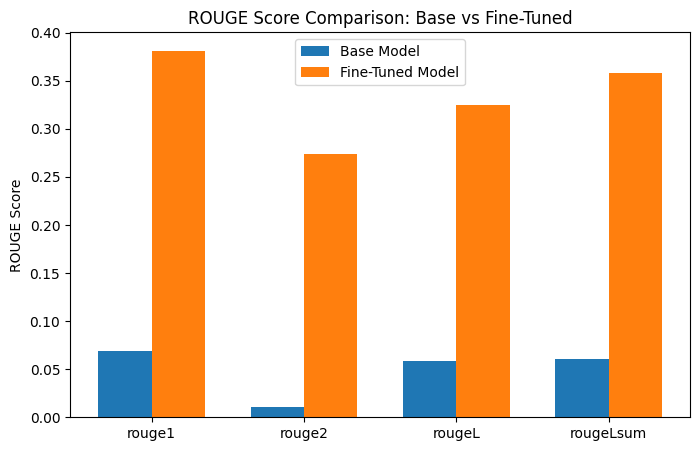

In [ ]:
#Define ROUGE metric
rouge = load("rouge")

#evaluation function
def evaluate_model(pipe, data, n_samples=100):
    preds, refs = [], []
    subset = data.sample(n=min(n_samples, len(data)), random_state=42).reset_index(drop=True)

    for _, row in subset.iterrows():
        input_text = f"### Input:\n{row['input_text']}\n\n### Output:\n"
        reference = row["output_text"]

        output = pipe(input_text, do_sample=False, num_return_sequences=1)[0]["generated_text"]

        if "### Output:" in output:
            pred = output.split("### Output:")[-1].strip()
        else:
            pred = output.strip()

        preds.append(pred)
        refs.append(reference)

    return preds, refs

#run evaluation
print("\nEvaluating base model...")
base_preds, refs = evaluate_model(base_pipe, test_data, n_samples=99)

print("Evaluating fine-tuned model...")
ft_preds, _ = evaluate_model(ft_pipe, test_data, n_samples=99)

#compute ROUGE
base_rouge = rouge.compute(predictions=base_preds, references=refs)
ft_rouge = rouge.compute(predictions=ft_preds, references=refs)

print("\n===== ROUGE Scores =====")
print("Base Model:", base_rouge)
print("Fine-Tuned Model:", ft_rouge)

#Visualize
labels = list(base_rouge.keys())
base_scores = [base_rouge[k] for k in labels]
ft_scores = [ft_rouge[k] for k in labels]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - width/2, base_scores, width, label="Base Model")
plt.bar(x + width/2, ft_scores, width, label="Fine-Tuned Model")

plt.xticks(x, labels)
plt.ylabel("ROUGE Score")
plt.title("ROUGE Score Comparison: Base vs Fine-Tuned")
plt.legend()
plt.show()


### Qualitative Analysis (Side-by-Side Comparison)

In [ ]:
# Qualitative Analysis

# Define a sample query and reference answer
sample_input = "I've been feeling really tired lately and have a persistent cough."
reference_output = """Based on your symptoms (tiredness, persistent cough), it looks like you may have Tuberculosis. Tuberculosis (TB) is an infectious disease usually caused by Mycobacterium tuberculosis (MTB) bacteria. Tuberculosis generally affects the lungs, but can also affect other parts of the body. Most infections do not have symptoms, in which case it is known as latent tuberculosis. About 10% of latent infections progress to active disease which, if left untreated, kills about half of the affected people. The classic symptoms of active TB are a chronic cough with blood-containing mucus, fever, night sweats, and weight loss. It was historically called consumption due to the weight loss. Infection of other organs can cause a wide range of symptoms. Consult doctor immediately. Here are some precautions you can take: wear mask, isolate, eat proteins, cough in napkin. Additional context: Tuberculosis is a significant public health issue in India, often associated with overcrowded living conditions and poverty. There are national programs in place for diagnosis and treatment. The Hindi term for Tuberculosis is 'Kshay Rog'. In rural areas, access to specialized care might be limited, emphasizing the importance of early detection and treatment at primary health centers."""


# Function to generate response from a model pipeline
def generate_response(pipe, input_text):
    prompt = f"### Input:\n{input_text}\n\n### Output:\n"
    output = pipe(prompt, max_new_tokens=128, do_sample=False, num_return_sequences=1)[0]["generated_text"]

    if "### Output:" in output:
        return output.split("### Output:")[-1].strip()
    else:
        return output.strip()

# Generate responses from base and fine-tuned models
print("Generating response from Base Model...")
base_response = generate_response(base_pipe, sample_input)

print("\nGenerating response from Fine-Tuned Model...")
ft_response = generate_response(ft_pipe, sample_input)

# Display the results
print("\n===== Qualitative Analysis =====")
print("\nSample Input:")
print(sample_input)

print("\nReference Output:")
print(reference_output)

print("\nBase Model Response:")
print(base_response)

print("\nFine-Tuned Model Response:")
print(ft_response)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Generating response from Base Model...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Generating response from Fine-Tuned Model...

===== Qualitative Analysis =====

Sample Input:
I've been feeling really tired lately and have a persistent cough.

Reference Output:
Based on your symptoms (tiredness, persistent cough), it looks like you may have Tuberculosis. Tuberculosis (TB) is an infectious disease usually caused by Mycobacterium tuberculosis (MTB) bacteria. Tuberculosis generally affects the lungs, but can also affect other parts of the body. Most infections do not have symptoms, in which case it is known as latent tuberculosis. About 10% of latent infections progress to active disease which, if left untreated, kills about half of the affected people. The classic symptoms of active TB are a chronic cough with blood-containing mucus, fever, night sweats, and weight loss. It was historically called consumption due to the weight loss. Infection of other organs can cause a wide range of symptoms. Consult doctor immediately. Here are some precautions you can take: wear m

## 6. Final Thoughts and Project Analysis

In this section, reflect on your approach, findings, and potential improvements.

### Project Summary
The goal of this project was to build a domain-specific, localized conversational AI using synthetic data and efficient fine-tuning techniques, meeting the "resource-constrained environment" challenge.
- My chosen **use case** was **An AI-powered Healthcare Reasoning/Consultation Assistant for India. This addresses the critical need to counter Western data bias in health models by grounding its responses with generated Indian context notes.** The model functions as a doctor, taking a natural language symptom query and providing a likely disease, precautions, a rationale, and advice on seeking professional help. **The reason for countering data bias is because most of these models are trained on western data and in those countries people encounter different diseases and have different symptoms whereas as compared to Africa or India (where data is scarce)**

- **Data Generation Process:**
  - Firstly I needed a dataset on Indian healthcare regarding the diseases and its associated symptoms for Indian demography and went on govt. webistes but due to lack of domain knowledge went to kaggle for more simpler stricter datasets. and found this dataset
https://www.kaggle.com/datasets/itachi9604/disease-symptom-description-dataset
  - **Initial Augmentation (Rule-Based):** Combined public Kaggle CSV data with programmed logic to derive a severity_score and a when_to_consult_doctor recommendation, the latter overriding to "Consult doctor immediately" for critical diseases.
  - **Contextual Synthesis (Gemma 3.2 1B-IT):** Used the Gemma model to produce high-quality rationale and indian_context_notes into a subset of the data (615 rows), explicitly localizing the knowledge.
  - **Q&A Formatting & Paraphrasing (Qwen 1.5 0.5B-Chat):** Used the efficient Qwen model to format the structured data into natural language input_text (patient query) and output_text (doctor response) pairs. This process was then repeated via paraphrasing to perform data augmentation, creating the final 1230-row dataset that was uploaded to the Hugging Face Hub (Deeptanshu13/synthetic_healthcare_data_qa_pairs).
- **Model Choice & Fine-Tuning:** The Llama 3.2 1B model was selected for its small size and compatibility with the Colab T4 GPU. I used Parameter-Efficient Fine-Tuning (PEFT) with LoRA (Low-Rank Adaptation) to train only a small percentage (approx. 0.9%) of the model parameters.
- **Main Results:** Evaluation using the ROUGE metric on the structured response format demonstrated a significant increase in performance.
- Schema used: { Input : {input_text} ,
Output: {output_text}
}


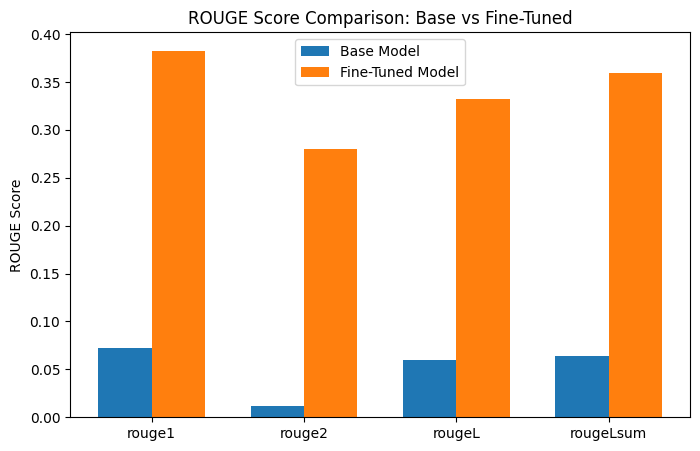

### Analysis of Results
- Performance Improvement: The fine-tuning process resulted ina measurable gain in performance. The base model scores confirm it had virtually zero ability to perform the complex, structured instruction-following task. The fine-tuned model's high ROUGE scores proves it successfully learned the required response structure and content patterns.
  - **PERFORMANCE GAINS**
for the base model ROUGE-1 = 0.073 & ROUGE-L = 0.383
for fine-tuned model ROUGE-1 = 0.060 & ROUGE-L = 0.333
this means a +31 and +27 points imporvment in ROUGE-1 and ROUGE-L performance

- The improvements were most clear in cases where the model had to bring together different pieces of information—like the disease, precautions, reasoning, and context—into one clear narrative. The fine-tuned model reliably included the Indian context notes, showing that it successfully picked up domain-specific, localized details.
- **Limitations:**
  - **Context Quality:** The quality of the synthetic Indian context notes depends on the generator model (Gemma 1B-IT). Since it isn’t a medical authority, some information may be inaccurate or incomplete—showing the trade-off between faster, cheaper generation and reliable medical accuracy.
  - Although this can be solved by searching the web more and collecting all data relevent to "Indian health context"
  - **Personal Limitation:** Because of my limited domain knowledge, I struggled to interpret much of the data from government websites, especially due to complex column names and information not directly relevant to this project. While the data itself is valuable, fully leveraging it would likely require a larger model to capture and make sense of it.

### Improvement Ideas
- **Improvement Ideas**
  - **Making the Dataset Better :**
    - Involve local experts (like doctors or traditional medicine practitioners) to check and improve the Indian context notes so they are accurate and culturally relevant.

    - Add more variety by translating questions into Hindi or other regional languages and then back into English, so the dataset reflects the way people actually speak.

 - **Improving the Model and Testing :**
    - If stronger hardware is available, try larger models (like Qwen-7B or Llama-3 8B) that can handle more complex reasoning.

    - Instead of only checking word overlap, also measure whether the answers are factually correct and make sense, with some human review included.
    
- What other fine-tuning approaches might work better?
  - Use instruction tuning or RLHF to align outputs with medical expectations.
  - Try LoRA or other lightweight methods on bigger models for better results at lower cost.
- If you had more computational resources, what would you do differently?
  - Fine-tune larger models (7B–13B) with richer multilingual, region-specific data.
  - Run broader experiments with stronger evaluation methods

### Learning Outcomes
- What insights did you gain about synthetic data generation?
  - Synthetic data isn’t just a replacement for missing data — it can actively teach a model new perspectives. Adding Indian context directly into the dataset helped the model learn culturally relevant knowledge it wouldn’t normally have.
- What did you learn about fine-tuning LLMs?
  - Fine-tuning with PEFT/LoRA is highly efficient: large models can be adapted to new domains with very few trainable parameters (<1%) and modest hardware, making it practical in resource-limited settings.
- What surprised you during this project?
  - That even when you feed LLMs with english text, some models like qwen may insert some chinese letters into your dataset (which is very rare by the way)
  - Also I knew about data augumentation and synthetic data generation but to actually do it, which is, have an LLMs generate training data to train another LLMs is surprising.

#### I have also documented the process and thinking through the comments in the code!

## 7. References

- [PEFT documentation](https://huggingface.co/docs/peft/tutorial/peft_model_config)
- [LoRA documentation](https://huggingface.co/docs/peft/task_guides/lora_based_methods)
- [hugging face llm-course](https://huggingface.co/learn/llm-course/chapter1/1?fw=pt)
- [hugging face how-to-login](https://huggingface.co/docs/huggingface_hub/how-to-login)
- [hugging face transformers](https://huggingface.co/docs/transformers/index)
- [hugging face trl documenation](https://huggingface.co/docs/trl/quickstart)
- [hugging face ROUGE metric documentation (code)](https://huggingface.co/spaces/evaluate-metric/rouge)
- [Turtorial video on fine tuning on llama model using LoRA method](https://www.youtube.com/watch?v=Vg3dS-NLUT4)
- [explainer video on Rouge](https://www.youtube.com/watch?v=TMshhnrEXlg&pp=ygUncm91Z2UgZXZhbHVhdGlvbiBtZXRyaWMgZXhwbGFpbmVyIHZpZGVv0gcJCfsJAYcqIYzv)


*This notebook was created as part of a Research Internship assignment.*